In [1]:
from matplotlib import pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
import time

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

epochs = 150
Sequence_length = 240  # Sequence-to-sequence model
hidden_size = 576 # 352
num_layers = 3
batch_size = 16
dropout_rate = 0.19
lr = 0.0003
step_size = 40
gamma = 0.25

True


In [3]:
## Data processing
Data = np.loadtxt('./Data_ESM_Paper.csv', delimiter=',', skiprows=0)
# 0: IC WindSpd; 1-25: WindSpd; 26: WaveEle; 27: BldPit; 28: TwrTopDx; 29: PltfDx; 30: TwrBsMy; 31: SubBsMy
Name = 'uT'  # uT, uP, MT, MS
print(Data.shape)
Cic = int(120/0.5)  # Length of each simulation
WindSpeed = np.arange(26, 51, 2)  # wind-speed range
IM = len(WindSpeed)

Fea_13 = np.array([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25])
Col = np.append(Fea_13, np.array([0, 26, 27, 28]))

input_size = len(Col) -1
output_size = 1

num_WF = 10*6*3  # Wind fields for each wind speed    TOTAL LENGTH: IM*num_WF*Cic
num_Train = 3*6*3  # Wind fields for each wind speed for training
num_Test = 1*6*3
num_Valid = 1*6*3

Data_Train = np.zeros([num_Train*Cic*IM, len(Col)])
Data_Valid = np.zeros([num_Valid*Cic*IM, len(Col)])
Data_Test = np.zeros([num_Test*Cic*IM, len(Col)])

for i in range(IM):
    Data_Train[num_Train*Cic*i: num_Train*Cic*(i+1), :] = Data[num_WF*Cic*i: num_Train*Cic + num_WF*Cic*i, Col]
    Data_Valid[num_Valid*Cic*i: num_Valid*Cic*(i+1), :] = Data[num_Train*Cic + num_WF*Cic*i: (num_Train+num_Valid)*Cic + num_WF*Cic*i, Col]
    Data_Test[num_Test*Cic*i: num_Test*Cic*(i+1), :] = Data[(num_Train+num_Test)*Cic + num_WF*Cic*i: (num_Train+num_Valid+num_Test)*Cic + num_WF*Cic*i, Col]

scaler = MinMaxScaler(feature_range=(0, 1))
X_Train = scaler.fit_transform(Data_Train[:, :-1]).reshape(-1, Sequence_length, input_size)
Y_Train = Data_Train[:, -1].reshape(-1, Sequence_length, output_size)
X_Valid = scaler.transform(Data_Valid[:, :-1]).reshape(-1, Sequence_length, input_size)
Y_Valid = Data_Valid[:, -1].reshape(-1, Sequence_length, output_size)
X_Test = scaler.transform(Data_Test[:, :-1]).reshape(-1, Sequence_length, input_size)
Y_Test = Data_Test[:, -1].reshape(-1, Sequence_length, output_size)

print(X_Train.shape)
print(X_Valid.shape)
print(X_Test.shape)
print(Y_Train.shape)
print(Y_Valid.shape)
print(Y_Test.shape)

(561600, 32)
(702, 240, 16)
(234, 240, 16)
(234, 240, 16)
(702, 240, 1)
(234, 240, 1)
(234, 240, 1)


In [4]:
class TensorDataset(Dataset):
    def __init__(self, data_tensor, target_tensor):
        self.data_tensor = data_tensor
        self.target_tensor = target_tensor

    def __getitem__(self, index):
        return self.data_tensor[index], self.target_tensor[index]

    def __len__(self):
        return len(self.data_tensor)

DataSet_train = TensorDataset(X_Train, Y_Train)
DataSet_valid = TensorDataset(X_Valid, Y_Valid)
DataSet_test = TensorDataset(X_Test, Y_Test)
TrainDataLoader = DataLoader(DataSet_train, batch_size=batch_size, shuffle=True, drop_last=False)
ValidDataLoader = DataLoader(DataSet_valid, batch_size=batch_size, shuffle=True, drop_last=False)
TestDataLoader = DataLoader(DataSet_test, batch_size=batch_size, shuffle=False, drop_last=False)

In [5]:
class Attention(nn.Module):
    def __init__(self, input_dim, use_scale=False, score_mode="dot"):
        super(Attention, self).__init__()
        self.use_scale = use_scale
        self.score_mode = score_mode
        self.scale = nn.Parameter(torch.ones(1)) if use_scale else None
        if score_mode == "concat":
            self.concat_score_weight = nn.Parameter(torch.Tensor(input_dim * 2).fill_(1.0))
        assert score_mode in ["dot", "concat"]

    def _calculate_scores(self, query, key):
        if self.score_mode == "dot":
            scores = torch.bmm(query, key.permute(0, 2, 1))
            if self.scale is not None:
                scores *= self.scale
        elif self.score_mode == "concat":
            q_reshaped = query.unsqueeze(-2)
            k_reshaped = key.unsqueeze(-3)
            if self.scale is not None:
                scores = self.concat_score_weight * torch.tanh(self.scale * (q_reshaped + k_reshaped)).sum(dim=-1)
            else:
                scores = self.concat_score_weight * torch.tanh(q_reshaped + k_reshaped).sum(dim=-1)

        return scores

    def _apply_scores(self, scores, value, mask=None):
        if mask is not None:
            scores.masked_fill_(mask == 0, float('-inf'))  # Assuming mask is 1 for valid positions and 0 for padding

        weights = torch.softmax(scores, dim=-1)
        output = torch.bmm(weights, value)
        return output, weights

    def forward(self, x, mask=None):
        query, key, value = x, x, x
        scores = self._calculate_scores(query, key)
        output, _ = self._apply_scores(scores, value, mask=mask)
        return output

# 定义模型结构
class BiLSTMAttModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super(BiLSTMAttModel, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_size*2, score_mode='dot')
        self.concat_layer = nn.Sequential(nn.Linear(hidden_size * 4, hidden_size), nn.ReLU())
        self.dropout = nn.Dropout(dropout_rate)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, inputs):
        lstm_out, _ = self.lstm(inputs)
        att_out = self.attention(lstm_out)
        merged = torch.cat([lstm_out, att_out], dim=-1)
        merged = self.concat_layer(merged)
        dropped = self.dropout(merged)
        outputs = self.output_layer(dropped)
        return outputs


In [25]:
##训练
model = BiLSTMAttModel(input_size, hidden_size, num_layers, output_size, dropout_rate).to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
criterion = nn.MSELoss().to(device)

In [7]:
def test():
    with torch.no_grad():
        valid_epoch_loss = []
        for inputs, targets in ValidDataLoader:
            inputs = torch.tensor(inputs).float().to(device)
            targets = torch.tensor(targets).float().to(device)
            outputs = model(inputs)
            loss = criterion(outputs.float(), targets.float())
            valid_epoch_loss.append(loss.item())
    return np.mean(valid_epoch_loss)

In [26]:
valid_loss = []
train_loss = []
best_loss = 1000
start_time = time.time()
print("Training Start")

for epoch in range(epochs):

    train_epoch_loss = []
    for inputs, targets in TrainDataLoader:
        optimizer.zero_grad()
        inputs = torch.tensor(inputs).float().to(device)
        targets = torch.tensor(targets).float().to(device)
        outputs = model(inputs)
        loss = criterion(outputs.float(), targets.float())
        loss.backward()
        optimizer.step()
        train_epoch_loss.append(loss.item())
    scheduler.step()

    train_loss.append(np.mean(train_epoch_loss))
    valid_epoch_loss = test()
    valid_loss.append(valid_epoch_loss)
    print("epoch:", epoch+1, "  train_epoch_loss:", train_epoch_loss[-1], " valid_epoch_loss:", valid_epoch_loss)

    if valid_epoch_loss < best_loss:
        best_loss = valid_epoch_loss
        best_model = model
        print("best_loss ----------------", best_loss, '----------------')
        torch.save(best_model.state_dict(), './Result/{}_Model.pth'.format(Name))

end_time = time.time()
elasped_time = end_time - start_time
print("Training time:", elasped_time)

Loss = np.zeros((len(valid_loss), 2))
Loss[:, 0] = np.array(train_loss)
Loss[:, 1] = np.array(valid_loss)
np.savetxt('./Result/{}_Loss.txt'.format(Name), Loss, delimiter=' ')

Training Start


C:\Users\Dell\AppData\Local\Temp\ipykernel_22572\3849096015.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).float().to(device)
C:\Users\Dell\AppData\Local\Temp\ipykernel_22572\3849096015.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().to(device)
C:\Users\Dell\AppData\Local\Temp\ipykernel_22572\3145287850.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).float().to(device)
C:\Users\Dell\AppData\Local\Temp\ipykernel_22572\31452878

epoch: 1   train_epoch_loss: 0.3374152183532715  valid_epoch_loss: 0.30139594376087187
best_loss ---------------- 0.30139594376087187 ----------------
epoch: 2   train_epoch_loss: 0.31298816204071045  valid_epoch_loss: 0.2757471978664398
best_loss ---------------- 0.2757471978664398 ----------------
epoch: 3   train_epoch_loss: 0.22686871886253357  valid_epoch_loss: 0.25731302599112194
best_loss ---------------- 0.25731302599112194 ----------------
epoch: 4   train_epoch_loss: 0.222320094704628  valid_epoch_loss: 0.2709421575069427
epoch: 5   train_epoch_loss: 0.19930775463581085  valid_epoch_loss: 0.24953760902086894
best_loss ---------------- 0.24953760902086894 ----------------
epoch: 6   train_epoch_loss: 0.22759075462818146  valid_epoch_loss: 0.263689856727918
epoch: 7   train_epoch_loss: 0.3702128231525421  valid_epoch_loss: 0.2641278018554052
epoch: 8   train_epoch_loss: 0.13287346065044403  valid_epoch_loss: 0.2106642097234726
best_loss ---------------- 0.2106642097234726 -----

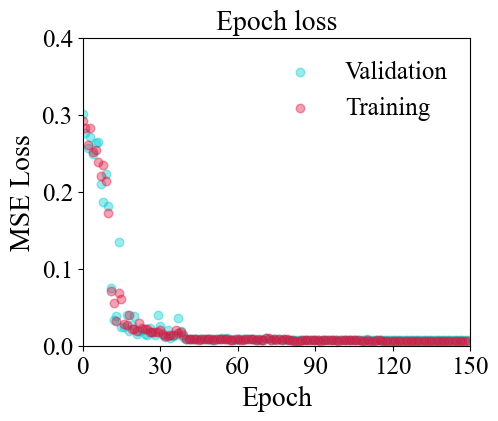

In [27]:
Epoch_loss = np.loadtxt('./Result/{}_Loss.txt'.format(Name))
valid_loss = Epoch_loss[:, 1]
train_loss = Epoch_loss[:, 0]

plt.rcParams['font.family'] = 'Times New Roman'
fig = plt.figure(facecolor='white', figsize=(5, 4))
plt.xlim(xmax=len(valid_loss), xmin=0)
x1 = [i for i in range(0, len(valid_loss))]
y1 = valid_loss
x2 = [i for i in range(0, len(train_loss))]
y2 = train_loss
colors1 = '#00CED4'
colors2 = '#DC143C'
area = np.pi*4**1.8
plt.scatter(x1, y1, s=area, c=colors1, alpha=0.4, label='Validation')
plt.scatter(x2, y2, s=area, c=colors2, alpha=0.4, label='Training')
plt.title('Epoch loss', fontsize=20)
plt.xlim(0, epochs)
plt.ylim(0, 0.4)
plt.xticks(np.arange(0, epochs+1, 30), fontsize=18)
plt.yticks(np.arange(0, 0.42, 0.1), fontsize=18)
# plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('MSE Loss', fontsize=20)
plt.legend(frameon=False, loc='upper right', fontsize=18)
fig.savefig("./Result/{}_Loss.jpg".format(Name), dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:
model = BiLSTMAttModel(input_size, hidden_size, num_layers, output_size, dropout_rate).to(device)
model.load_state_dict(torch.load('./Result/{}_Model.pth'.format(Name)))
model.eval()

C:\Users\Dell\AppData\Local\Temp\ipykernel_22572\3454407233.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).float().to(device)
C:\Users\Dell\AppData\Local\Temp\ipykernel_22572\3454407233.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().to(device)


MSE =  0.0077496255
MAE =  0.06574302
R2 Score =  0.973292257520207


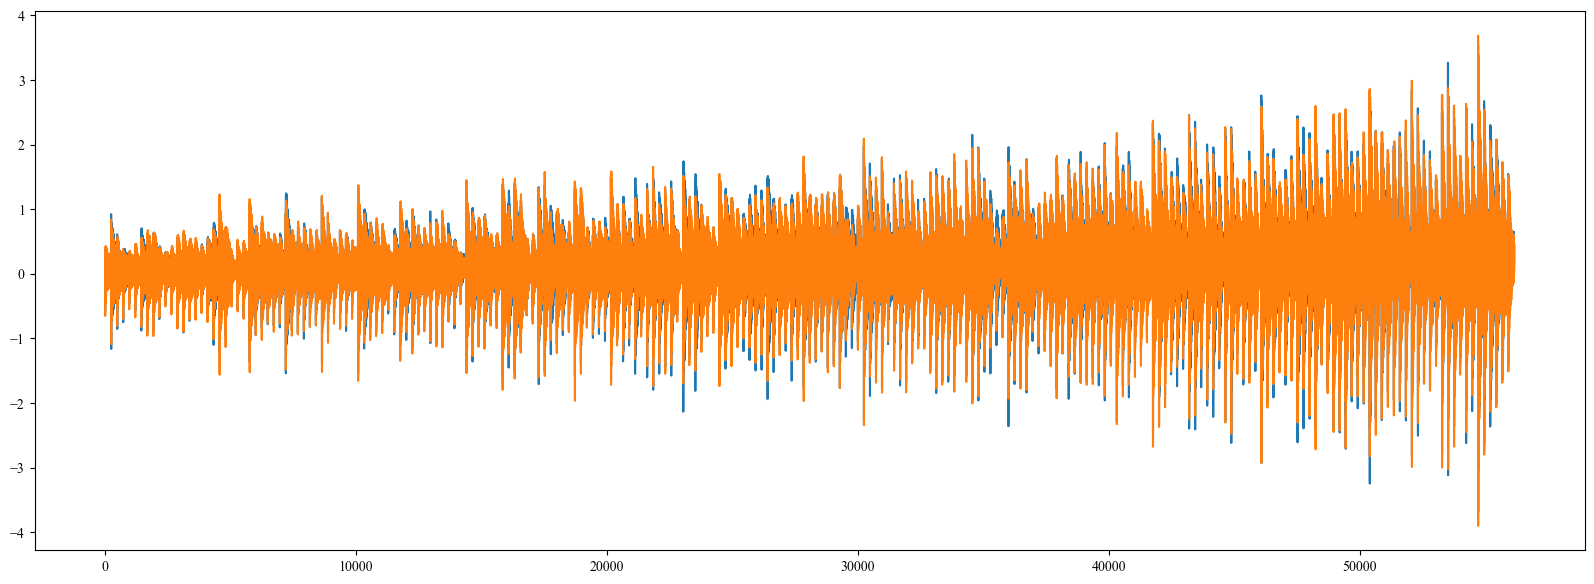

In [28]:
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, targets in TestDataLoader:
        inputs = torch.tensor(inputs).float().to(device)
        targets = torch.tensor(targets).float().to(device)
        outputs = model(inputs)
        outputs = list(outputs.cpu().numpy().reshape([1, -1])[0])
        targets = list(targets.cpu().numpy().reshape([1, -1])[0])
        y_pred.extend(outputs)
        y_true.extend(targets)

Y = np.zeros((len(y_true), 2))
Y[:, 0] = np.array(y_true)
Y[:, 1] = np.array(y_pred)
np.savetxt('./Result/{}_testY.txt'.format(Name), Y, delimiter=' ')

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
Error_mse = mean_squared_error(y_pred, y_true)
Error_mae = mean_absolute_error(y_pred, y_true)
R2_Score = r2_score(y_pred, y_true)
print('MSE = ', Error_mse)
print('MAE = ', Error_mae)
print('R2 Score = ', R2_Score)

fig1 = plt.figure(facecolor='white', figsize=(20, 7))
len_ = [i for i in range(len(y_true))]
plt.plot(len_, y_true, label='y_true')
plt.plot(len_, y_pred, label='y_pred')
plt.show()

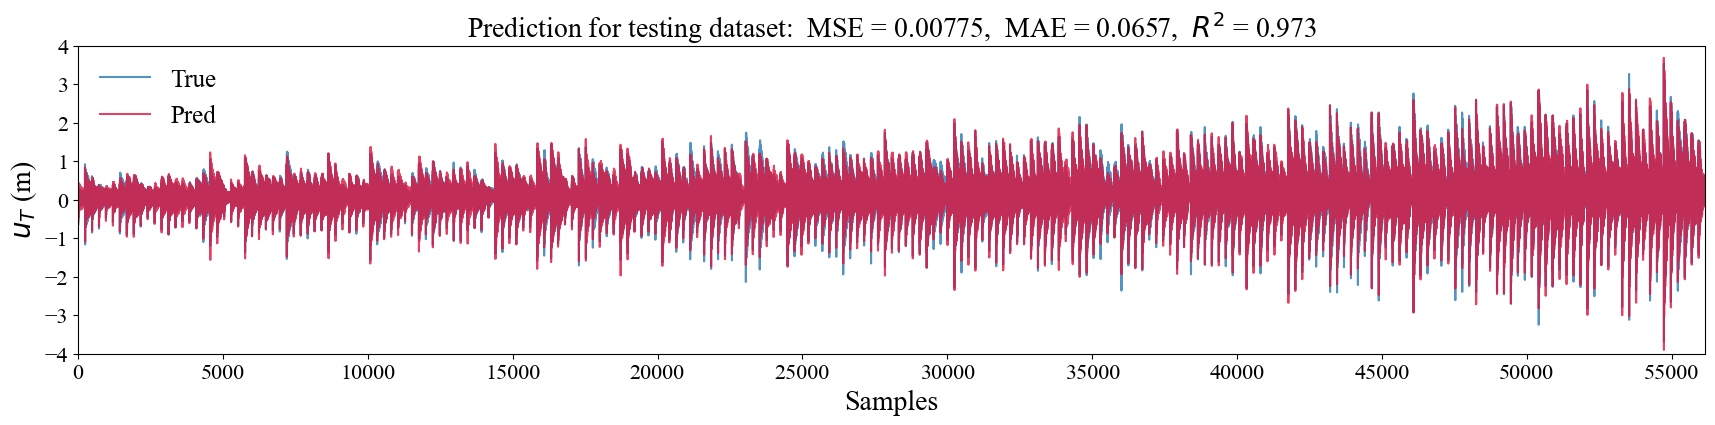

In [22]:
Y = np.loadtxt('./Result/uT_testY.txt', delimiter=' ')
y_true = Y[:, 0]
y_pred = Y[:, 1]
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
Error_mse = mean_squared_error(y_pred, y_true)
Error_mae = mean_absolute_error(y_pred, y_true)
R2_Score = r2_score(y_pred, y_true)

plt.rcParams['font.family'] = 'Times New Roman'
fig = plt.figure(facecolor='white', figsize=(21, 4))
len_ = [i for i in range(len(y_true))]
colors1 = '#2878B5'
colors2 = '#DC143C'
plt.plot(len_, y_true, c=colors1, alpha=0.8, label='True')
plt.plot(len_, y_pred, c=colors2, alpha=0.8, label='Pred')
plt.title(r'Prediction for testing dataset:  MSE = {:.5f},  MAE = {:.4f},  $R^2$ = {:.3f}'.format(Error_mse, Error_mae, R2_Score), fontsize=20)
plt.xlim(0, len(y_true))
plt.ylim(-4, 4)
plt.xticks(np.arange(0, len(y_true), 5000), fontsize=16)
plt.yticks(np.arange(-4, 4.1, 1), fontsize=16)
# plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.xlabel('Samples', fontsize=20)
plt.ylabel(r'$\mathit{u}_T$ (m)', fontsize=20, fontname='Times New Roman')
plt.legend(frameon=False, loc='upper left', fontsize=18)
fig.savefig("./Result/uT_Test.jpg", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

R2_Amp =  0.9318413189906598


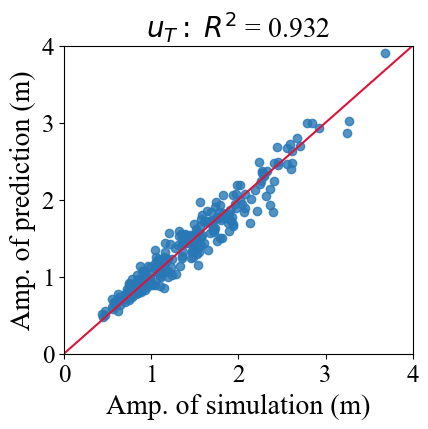

In [20]:
seq_len = 240
num_Test = 1*6*3*13
Amp_true = []
Amp_pred = []
for i in range(num_Test):
    seq_true = y_true[i*seq_len:(i+1)*seq_len]
    seq_pred = y_pred[i*seq_len:(i+1)*seq_len]
    Amp_true.append(np.max(np.abs(seq_true)))
    Amp_pred.append(np.max(np.abs(seq_pred)))

from sklearn.metrics import r2_score
R2_Amp = r2_score(Amp_pred, Amp_true)
print('R2_Amp = ', R2_Amp)

plt.rcParams['font.family'] = 'Times New Roman'
fig = plt.figure(facecolor='white', figsize=(4.5, 4))
len_ = [i for i in range(len(y_true))]
colors1 = '#2878B5'
colors2 = '#DC143C'
plt.scatter(Amp_true, Amp_pred, c=colors1, alpha=0.8)
plt.plot([0, 4], [0, 4], c=colors2, alpha=1)
plt.title(r'$u_T:$ $R^2$ = {:.3f}'.format(R2_Amp), fontsize=20, fontname='Times New Roman')
plt.xlim(0, 4)
plt.ylim(0, 4)
plt.xticks(np.arange(0, 4.1, 1), fontsize=18)
plt.yticks(np.arange(0, 4.1, 1), fontsize=18)
plt.xlabel('Amp. of simulation (m)', fontsize=20)
plt.ylabel('Amp. of prediction (m)', fontsize=20, fontname='Times New Roman')
fig.savefig("D:/Research/5-Deep_Learning/Code for paper/LSTM/ESM/Result/uT_Amp0.jpg", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [15]:
Y_true = np.array(y_true).reshape([-1, Sequence_length])
Y_pred = np.array(y_pred).reshape([-1, Sequence_length])
Seq_Score = []
for i in range(len(Y_true)):
    Seq_Score.append(r2_score(Y_pred[i], Y_true[i]))
Min_R2, Min_Loc = min(Seq_Score), Seq_Score.index(min(Seq_Score))
Max_R2, Max_Loc = max(Seq_Score), Seq_Score.index(max(Seq_Score))
print('Min_Val = ', Min_R2, ' Min_Loc = ', Min_Loc)
print('Max_Val = ', Max_R2, ' Max_Loc = ', Max_Loc)
# np.savetxt('./Result/uT_SeqScore.txt', Seq_Score, delimiter=' ')
print(np.min(Seq_Score))

Min_Val =  0.5799944780439679  Min_Loc =  70
Max_Val =  0.9958743326525968  Max_Loc =  153
0.5799944780439679


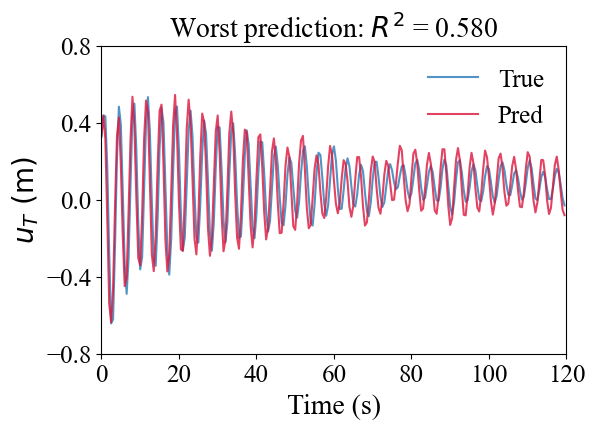

In [35]:
plt.rcParams['font.family'] = 'Times New Roman'
fig = plt.figure(facecolor='white', figsize=(6, 4))
x_ = [i*0.5 for i in range(Sequence_length)]
y1 = Y_pred[Min_Loc]
y2 = Y_true[Min_Loc]
colors1 = '#2878B5'
colors2 = '#DC143C'
plt.plot(x_, y2, c=colors1, alpha=0.8, label='True')
plt.plot(x_, y1, c=colors2, alpha=0.8, label='Pred')
plt.title(r'Worst prediction: $R^2$ = {:.3f}'.format(Min_R2), fontsize=20)
plt.xlim(0, 120)
plt.ylim(-0.8, 0.8)
plt.xticks(np.arange(0, 121, 20), fontsize=18)
plt.yticks(np.arange(-0.8, 0.9, 0.4), fontsize=18)
# plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'$\mathit{u}_T$ (m)', fontsize=20, fontname='Times New Roman')
plt.legend(frameon=False, loc='upper right', fontsize=18)
fig.savefig("./Result/{}_MinR2.jpg".format(Name), dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

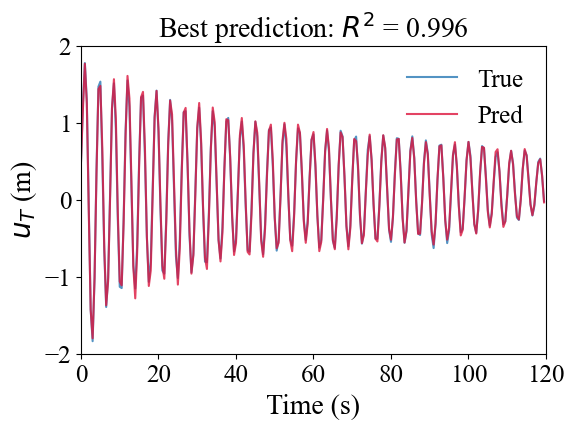

In [24]:
plt.rcParams['font.family'] = 'Times New Roman'
fig = plt.figure(facecolor='white', figsize=(6, 4))
x_ = [i*0.5 for i in range(Sequence_length)]
y1 = Y_pred[Max_Loc]
y2 = Y_true[Max_Loc]
colors1 = '#2878B5'
colors2 = '#DC143C'
plt.plot(x_, y2, c=colors1, alpha=0.8, label='True')
plt.plot(x_, y1, c=colors2, alpha=0.8, label='Pred')
plt.title(r'Best prediction: $R^2$ = {:.3f}'.format(Max_R2), fontsize=20)
plt.xlim(0, 120)
plt.ylim(-2.0, 2.0)
plt.xticks(np.arange(0, 121, 20), fontsize=18)
plt.yticks(np.arange(-2, 2.1, 1), fontsize=18)
# plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'$\mathit{u}_T$ (m)', fontsize=20, fontname='Times New Roman')
plt.legend(frameon=False, loc='upper right', fontsize=18)
fig.savefig("./Result/uT_MaxR2.jpg", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [11]:
import rainflow
cycles_true = np.array(rainflow.count_cycles(Y_true.flatten()))
cycles_pred = np.array(rainflow.count_cycles(Y_pred.flatten()))

cycles_min = np.min([np.min(cycles_true[:, 0]), np.min(cycles_pred[:, 0])])
cycles_max = np.max([np.max(cycles_true[:, 0]), np.max(cycles_pred[:, 0])])
num = 20 + 1

step = (cycles_max - cycles_min) / (num-1)
buckets_true = np.zeros(num)
buckets_pred = np.zeros(num)

for i in range(len(cycles_true)):
    index_ = int((cycles_true[i, 0] - cycles_min) // step)
    buckets_true[index_] += cycles_true[i, 1]

for i in range(len(cycles_pred)):
    index_ = int((cycles_pred[i, 0] - cycles_min) // step)
    buckets_pred[index_] += cycles_pred[i, 1]

RainFlow_R2 = r2_score(buckets_pred, buckets_true)
print('RainFlow_R2 = ', RainFlow_R2)

RainFlow_R2 =  0.9886745798474603


21


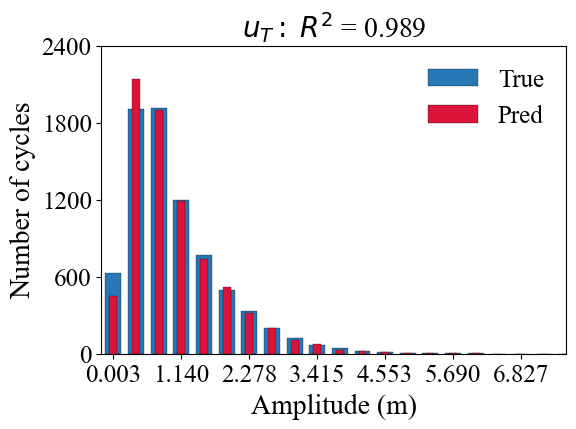

In [21]:
bucket_values = np.arange(cycles_min, cycles_max + step, step).tolist()
print(len(bucket_values))
Xticks = [bucket_values[3*i] for i in range(7)]
plt.rcParams['font.family'] = 'Times New Roman'
fig = plt.figure(facecolor='white', figsize=(6, 4))
colors1 = '#2878B5'
colors2 = '#DC143C'
plt.bar(bucket_values, buckets_true, color=colors1, width=step_size/150, label='True', edgecolor='black', linewidth=0.2)
plt.bar(bucket_values, buckets_pred, color=colors2, width=step_size/300, label='Pred', edgecolor='black', linewidth=0.2)
plt.xlim(-0.2, cycles_max)
plt.ylim(0, 2400)
plt.xlabel('Amplitude (m)', fontsize=20)
plt.ylabel('Number of cycles', fontsize=20)
plt.title(r'$u_T:$ $R^2$ = {:.3f}'.format(RainFlow_R2), fontsize=20, fontname='Times New Roman')
plt.xticks(Xticks, fontsize=18)
plt.yticks(np.arange(0, 2500, 600), fontsize=18)
plt.legend(frameon=False, loc='upper right', fontsize=18)
fig.savefig("./Result/uT_Rainflow_Test0.jpg", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()